In [29]:
import json 
import pandas as pd
import numpy as np

import rdflib
import collections
import missingno as msno
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
import plotly.plotly as py
import matplotlib.pyplot as plt

init_notebook_mode(connected=True)

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def nt_to_csv(path, source):
    # converts source and target files
    # load the .nt file
    g = rdflib.Graph()
    if source: 
        g.parse(path+'/source', format="nt")
    else:
        g.parse(path+'/target', format="nt")
    # put it into a dictionary
    phone_source = collections.defaultdict(dict)
    for s,p,o in g:
        phone_source[str(s)][str(p)] = str(o)

    phone_source = pd.DataFrame.from_dict(phone_source, orient='index')
    
    if source: # product pages
        d =[]
        for i in list(phone_source.index):
            d.append(i[24:])
        phone_source['page_id']=d
        phone_source=change_col_names(phone_source, 'page')
    else: # catalog
        d =[]
        for i in list(phone_source.index):
            d.append(i[28:])
        phone_source['catalog_id']=d
        phone_source=change_col_names(phone_source, 'cat')
    

    return phone_source

In [4]:
def change_col_names(df, prefix):
    # change column names of the dataframe and returns it
    result=[]
    for c in df.columns:
        if(c== 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'):
            result.append('page_type')
        elif(c == 'page_id'):
            result.append('page_id')
        elif (c== 'catalog_id'):
            result.append('catalog_id')
        else:
            result.append(prefix+'_'+c.split('http://schema.org/Product/')[1])
    df.columns=result
    return df

In [5]:
def get_goldstandard(correspondence_path):
    # 'GoldStandard/Correspondences/phonecorrespndences.csv'
    cor_phone=pd.read_csv(correspondence_path+'/correspondence.csv',sep=';',names=['id_webpage','catalog_id','match'],header=0)
    return cor_phone

In [6]:
def get_product_cat(correspondence_path):
    # gets the product catalog
    id_prodcat_info= pd.read_json(correspondence_path+'/product_catalog.json', encoding='utf-8')
    id_prodcat_info.columns=['prodcat_'+c for c in id_prodcat_info.columns]
    id_prodcat_info = id_prodcat_info[['prodcat_product_name','prodcat_id']]
    return id_prodcat_info

In [7]:
def merge(prod_cat,gold,target,source,headphone):
    # Merge step 1:
    # We need product catalog ids to merge with target, because the target doesn't have names and therefore cannnot 
    # be joined with the gold standard
    if(headphone):
        # in headphone dataset, there were two products with the same name, but different ids so we are dropping one of them
        target=target[~target['catalog_id'].isin(['20f90193-ab81-4a40-baf4-b97c5d275852'])]
        prod_cat=prod_cat[~prod_cat['prodcat_id'].isin(['20f90193-ab81-4a40-baf4-b97c5d275852'])]
        
    prod_cat1=pd.merge(target, prod_cat, how='inner', left_on='catalog_id',right_on='prodcat_id')
    # Merge step 2: Add web page columns and add it to the correspondences
    phone_getsource=pd.merge(gold, source, how='inner',left_on='id_webpage',right_on='page_id')
    # Merge step 3: Add product catalog columns and add it to the correspondences
    phone_result=pd.merge(phone_getsource, prod_cat1, how='inner',left_on='catalog_id',right_on='prodcat_product_name')
    phone_result=phone_result.drop(['page_type_y','page_type_x','catalog_id_x','catalog_id_y','page_id'],axis=1)
    print('Product catalog shape (target):',target.shape)
    print('Product catalog after merging with extracted:',prod_cat.shape)
    print('Gold standard shape:',gold.shape)
    print('Product pages shape (source):',source.shape)
    print('Merge 1- to get id of producat catalog:',prod_cat1.shape)
    print('Merge 2- web pages:',phone_getsource.shape)
    print('Merge 3- product catalog added:',phone_result.shape)
    
    print('**********************************')
    print('GS: Number of unique products from prodcat:',gold['catalog_id'].nunique())
    print('GS: Number of unique webpages:',gold['id_webpage'].nunique())
    print('Final table:Number of unique products from prodcat:',phone_result['prodcat_id'].nunique())
    print('Final table:Number of unique webpages:',phone_result['id_webpage'].nunique())
    print('Matches:')
    print(phone_result['match'].value_counts())
    print('Available in product catalog, but not in gold standard:',len(set(prod_cat['prodcat_product_name'].unique())- set(gold['catalog_id'].unique())))
    print('Available in gold standard, but not in product catalog:',len(set(gold['catalog_id'].unique())-set(prod_cat['prodcat_product_name'].unique())))
    print('Available in crawled pages, but not in gold standard:',len(set(source['page_id'].unique())- set(gold['id_webpage'].unique())))
    print('Available in gold standard, but not in crawled pages:',len(set(gold['id_webpage'].unique())-set(source['page_id'].unique())))
    return phone_result
    

In [8]:
def get_dataset(path,headphone=False):
    source_df=nt_to_csv(path, True)
    target_df=nt_to_csv(path, False)
    gold_df=get_goldstandard(path)
    prod_cat=get_product_cat(path)
    result=merge(prod_cat,gold_df,target_df,source_df,headphone)
    return result

In [9]:
def get_stats_table(phone_result_sub,only_page_columns,only_cat_columns):
    no_count=[phone_result_sub[i].count() for i in list(phone_result_sub.columns)]
    no_unique =[phone_result_sub[i].nunique() for i in list(phone_result_sub.columns)]
    no_missing=pd.DataFrame(phone_result_sub.isna().sum())[0].values
    percent_mis=np.round(no_missing/phone_result_sub.shape[0],3)
    page_mis=['1' if i in only_page_columns else '0' for i in list(phone_result_sub.columns)]
    cat_mis=['1' if i in only_cat_columns else '0' for i in list(phone_result_sub.columns)]
    top_row= [phone_result_sub[i].value_counts(dropna=False).index[0] for i in list(phone_result_sub.columns)]
    no_freq=[phone_result_sub[i].value_counts(dropna=False).values[0] for i in list(phone_result_sub.columns)]
    phone_stat=pd.DataFrame({'column_name':list(phone_result_sub.columns),'count':no_count, 'no_unique': no_unique, 'no_missing':no_missing, 'percent_missing': percent_mis, 
                  'only in page':page_mis, 'only in catalog':cat_mis, 'most_freq':top_row, 'no_most_freq': no_freq})
    phone_stat['most_freq']=phone_stat['most_freq'].replace(np.NaN, 'nan')

    phone_stat=phone_stat.set_index('column_name')
    return phone_stat

# 1. Creating the Datasets

## 1.1. Phones

In [10]:
phone_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Dataset/Phone'
phone_result=get_dataset(phone_path)
#phone_result.to_csv('phone_merged.csv')
phone_result.head()

Product catalog shape (target): (50, 31)
Product catalog after merging with extracted: (50, 2)
Gold standard shape: (24999, 3)
Product pages shape (source): (447, 29)
Merge 1- to get id of producat catalog: (50, 33)
Merge 2- web pages: (22349, 32)
Merge 3- product catalog added: (21455, 60)
**********************************
GS: Number of unique products from prodcat: 50
GS: Number of unique webpages: 500
Final table:Number of unique products from prodcat: 48
Final table:Number of unique webpages: 447
Matches:
0    21237
1      218
Name: match, dtype: int64
Available in product catalog, but not in gold standard: 2
Available in gold standard, but not in product catalog: 2
Available in crawled pages, but not in gold standard: 0
Available in gold standard, but not in crawled pages: 53


id_webpage  match             page_warc  \
0   node5fd6d025f29b89ff319c853d0e33744      0  ebay.com0.warc.nq.gz   
1  nodee9affe60fbe185b64feb5811d2e43159      0  ebay.com0.warc.nq.gz   
2  nodeb1d0ceb9797fd339c5f7c04aa76a7af1      0  ebay.com0.warc.nq.gz   
3    node12b450a88f0d6b897758f676414c61      0  ebay.com0.warc.nq.gz   
4    node9ace9d5daf49116fed3f11241dff6d      0  ebay.com0.warc.nq.gz   

  page_phone_type page_rear_cam_resolution page_display_size page_memory  \
0          one m9                   20.0mp              5 in        32gb   
1              m9                    20 mp              5 in        32gb   
2          one m9                    20 mp              5 in        32gb   
3          one m9                      NaN               NaN        32gb   
4          one m9                    20 mp              5 in        32gb   

  page_processor_type                                           page_url  \
0                 NaN  http://www.ebay.com/itm/blocked-htc-one-m9-32g...   
1                 NaN  http://www.ebay.com/itm/works-perfect-htc-one-...   
2                 NaN  http://www.ebay.com/itm/unlocked-htc-one-m9-32...   
3                 NaN  http://www.ebay.com/itm/refurbished-htc-one-m9...   
4                 NaN  http://www.ebay.com/itm/nice-factory-unlocked-...   

       page_color                               page_mpn page_brand  \
0  gold on silver                                    NaN        htc   
1   gunmetal gray                             htc6535lvw        htc   
2   gunmetal gray                                  6735a        htc   
3            gold                                opja120        htc   
4  gold on silver  ebay_htconem932gbgoldonsilverunlocked        htc   

  page_computer_operating_system page_product_type page_dimensions  \
0                            NaN        smartphone             NaN   
1                            NaN        smartphone             NaN   
2                            NaN        smartphone             NaN   
3                            NaN               NaN             NaN   
4                        android        smartphone             NaN   

  page_weight page_modelnum page_product_code page_depth page_phone_carrier  \
0     5.54 oz           NaN               NaN    0.38 in           t-mobile   
1     5.54 oz           NaN               NaN    0.38 in            verizon   
2     5.54 oz           NaN               NaN    0.38 in               at&t   
3         NaN           NaN               NaN        NaN           t-mobile   
4     5.54 oz           NaN               NaN    0.38 in           unlocked   

  page_height page_display_resolution page_wattage page_width  \
0    5.69 in.                     NaN      2840mah    2.74 in   
1     5.69 in                     NaN      2840mah    2.74 in   
2     5.69 in                     NaN      2840mah    2.74 in   
3         NaN                     NaN          NaN        NaN   
4     5.69 in                     NaN      2840mah    2.74 in   

  page_product_gtin page_ram page_front_cam_resolution page_manufacturer  \
0               NaN      NaN                       NaN               NaN   
1               NaN      NaN                       NaN               NaN   
2      821793045111      NaN                       NaN               NaN   
3               NaN      NaN                       NaN               NaN   
4               NaN      NaN                       NaN               NaN   

  page_body_material       cat_dimensions cat_product_gtin cat_manufacturer  \
0                NaN  138.1 x 67 x 6.9 mm   00885909950997                    
1                NaN  138.1 x 67 x 6.9 mm   00885909950997                    
2                NaN  138.1 x 67 x 6.9 mm   00885909950997                    
3                NaN  138.1 x 67 x 6.9 mm   00885909950997                    
4                NaN  138.1 x 67 x 6.9 mm   00885909950997                    

  cat_display_size cat_processor_typ

## 1.2. Headphone

In [11]:
hp_path ='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Dataset/Headphone'
hp_result=get_dataset(hp_path,True)
#hp_result.to_csv('hp_merged.csv')
hp_result.head()

Product catalog shape (target): (50, 39)
Product catalog after merging with extracted: (50, 2)
Gold standard shape: (25499, 3)
Product pages shape (source): (444, 30)
Merge 1- to get id of producat catalog: (50, 41)
Merge 2- web pages: (22643, 33)
Merge 3- product catalog added: (22199, 69)
**********************************
GS: Number of unique products from prodcat: 50
GS: Number of unique webpages: 500
Final table:Number of unique products from prodcat: 49
Final table:Number of unique webpages: 444
Matches:
0    21947
1      252
Name: match, dtype: int64
Available in product catalog, but not in gold standard: 1
Available in gold standard, but not in product catalog: 1
Available in crawled pages, but not in gold standard: 0
Available in gold standard, but not in crawled pages: 56


id_webpage  match page_compatibility  \
0     node449b610bd3ad6439d1b26190266d5      0                NaN   
1  node4b4dee215b51f2eb45a114409ce7eda6      0                NaN   
2    node52a9f6bc8fa1772a0f6a2832641fa1      0                NaN   
3  node6d72a28b4e6d7d1aff11ebab95221fa1      0                NaN   
4     node88b5b595637fff2942878d19b2358      0                NaN   

  page_impedance        page_mpn page_brand page_model  \
0        62 ohms  does not apply        akg   k712 pro   
1        62 ohms  does not apply        akg   k712 pro   
2            NaN  does not apply        akg   k712 pro   
3        62 ohms  does not apply        akg   k712 pro   
4            NaN  does not apply        akg        NaN   

  page_headphones_form_factor page_sensitivity             page_warc  \
0      ear-cup (over the ear)              NaN  ebay.com0.warc.nq.gz   
1      ear-cup (over the ear)              NaN  ebay.com0.warc.nq.gz   
2                         NaN              NaN  ebay.com0.warc.nq.gz   
3      ear-cup (over the ear)              NaN  ebay.com0.warc.nq.gz   
4                         NaN              NaN  ebay.com0.warc.nq.gz   

                                            page_url page_color page_series  \
0  http://www.ebay.com/itm/brand-new-akg-k712-pro...      black         NaN   
1  http://www.ebay.com/itm/brand-new-akg-k712-pro...      black         NaN   
2  http://www.ebay.com/itm/brand-new-akg-k712-pro...        NaN         NaN   
3  http://www.ebay.com/itm/brand-new-akg-k712-pro...      black         NaN   
4  http://www.ebay.com/itm/brand-new-akg-k712-pro...        NaN    k712 pro   

  page_warranty page_headphones_technology page_microphone_sensitivity  \
0           NaN                        NaN                         NaN   
1           NaN                        NaN                         NaN   
2           NaN                        NaN                         NaN   
3           NaN                        NaN                         NaN   
4           NaN                        NaN                         NaN   

  page_thd page_product_type page_connectivity_technology page_weight  \
0      NaN               NaN                          NaN         NaN   
1      NaN               NaN                          NaN         NaN   
2      NaN               NaN                          NaN         NaN   
3      NaN               NaN                          NaN         NaN   
4      NaN               NaN                          NaN         NaN   

  page_frequency_response page_max_input_power page_product_gtin  \
0                     NaN                  NaN    does not apply   
1                     NaN                  NaN    does not apply   
2                     NaN                  NaN    does not apply   
3                     NaN                  NaN    does not apply   
4                     NaN                  NaN    does not apply   

  page_headphones_cup_type page_included_accessories page_height page_width  \
0            open-air type                       NaN         NaN        NaN   
1            open-air type                       NaN         NaN        NaN   
2            open-air type                       NaN         NaN        NaN   
3            open-air type                       NaN         NaN        NaN   
4            open-air type                       NaN         NaN        NaN   

  page_magnet_material page_cables_included page_microphone  \
0                  NaN                  NaN             NaN   
1                  NaN                  NaN             NaN   
2                  NaN                  NaN             NaN   
3                  NaN                  NaN             NaN   
4                  NaN                  NaN             NaN   

  cat_headphones_cup_type cat_height  \
0                  closed              
1                  closed              
2                  closed              
3                  closed              
4         

## 1.3. TVs

In [12]:
tv_path='/Users/bengikoseoglu/Documents/Masters/Semester4/Thesis/Dataset/TVs'
tv_result=get_dataset(tv_path)
#tv_result.to_csv('tv_merged.csv')
tv_result.head()

Product catalog shape (target): (60, 78)
Product catalog after merging with extracted: (60, 2)
Gold standard shape: (29999, 3)
Product pages shape (source): (428, 479)
Merge 1- to get id of producat catalog: (60, 80)
Merge 2- web pages: (25679, 482)
Merge 3- product catalog added: (25679, 556)
**********************************
GS: Number of unique products from prodcat: 60
GS: Number of unique webpages: 500
Final table:Number of unique products from prodcat: 60
Final table:Number of unique webpages: 428
Matches:
0    25495
1      184
Name: match, dtype: int64
Available in product catalog, but not in gold standard: 0
Available in gold standard, but not in product catalog: 0
Available in crawled pages, but not in gold standard: 0
Available in gold standard, but not in crawled pages: 72


id_webpage  match page_usb_ports  \
0  node2adaa221ac4791c47f29f345972f1c91      0            NaN   
1   nodeb452c577135dea4d89c4fcd40b9ac4f      0            NaN   
2  nodef741bd19171e3c5f35e514b43c112972      0            NaN   
3  node62aa28f37676c392289b6393a7a550e8      0            NaN   
4   node66e1a3264db98d4cab3dbe4f9295858      0            NaN   

  page_viewable_size page_yearly_operating_cost page_height_with_stand  \
0              43 in                        NaN                    NaN   
1              43 in                        NaN                    NaN   
2              43 in                        NaN                    NaN   
3              43 in                        NaN                    NaN   
4              43 in                        NaN                    NaN   

  page_input_video_formats page_depth page_connectivity page_speakers_qty  \
0                      NaN        NaN               NaN               NaN   
1                      NaN        NaN               NaN               NaN   
2                      NaN        NaN               NaN               NaN   
3                      NaN        NaN               NaN               NaN   
4                      NaN        NaN               NaN               NaN   

  page_yearly_consumption page_media_card_slot  \
0                     NaN                  NaN   
1                     NaN                  NaN   
2                     NaN                  NaN   
3                     NaN                  NaN   
4                     NaN                  NaN   

                                            page_url page_height  \
0  http://www.walmart.com/ip/vizio-d43-c1-43-1080...         NaN   
1  http://www.walmart.com/ip/vizio-d43-c1-43-1080...         NaN   
2  http://www.walmart.com/ip/vizio-d43-c1-43-1080...         NaN   
3  http://www.ebay.com/itm/lg-43uf6400-43-inch-4k...         NaN   
4  http://www.ebay.com/itm/lg-43uf6400-43-inch-4k...         NaN   

  page_depth_with_stand page_wall_mountable page_weight page_rf_antenna_input  \
0                   NaN                 NaN         NaN                   NaN   
1                   NaN                 NaN         NaN                   NaN   
2                   NaN                 NaN         NaN                   NaN   
3                   NaN                 NaN         NaN                   NaN   
4                   NaN                 NaN         NaN                   NaN   

                 page_warc page_brand page_display_resolution  \
0  walmart.com0.warc.nq.gz      vizio                   1080p   
1  walmart.com0.warc.nq.gz      vizio            1080p (hdtv)   
2  walmart.com0.warc.nq.gz      vizio            1080p (hdtv)   
3     ebay.com0.warc.nq.gz         lg                     NaN   
4     ebay.com0.warc.nq.gz         lg                     NaN   

  page_display_type page_sound_effects page_hdmi_ports page_3d_technology  \
0               led                NaN             NaN                NaN   
1               led                NaN             NaN                NaN   
2               led                NaN             NaN                NaN   
3             2160p                NaN             NaN                NaN   
4             2160p                NaN             NaN                NaN   

  page_warranty page_product_code page_additional_features page_smart_capable  \
0           NaN         555161914                      NaN                NaN   
1           NaN         555161914                      NaN                NaN   
2           NaN         555161914                      NaN                NaN   
3           NaN               NaN                      NaN                NaN   
4           NaN               NaN                      NaN                NaN   

  page_model page_weight_with_stand page_pc_input page_wall_mount_dimensions  \
0     d43-c1                    NaN           NaN                        NaN   
1     d43-c1                    

# 2. Statistics

## 2.1. Phones

In [13]:
phone_result=pd.read_csv('phone_merged.csv')
phone_result=phone_result.drop(['Unnamed: 0','id'],axis=1)
phone_result.head()

id_webpage  match page_brand  \
0   node5fd6d025f29b89ff319c853d0e33744      0        htc   
1  nodee9affe60fbe185b64feb5811d2e43159      0        htc   
2  nodeb1d0ceb9797fd339c5f7c04aa76a7af1      0        htc   
3    node12b450a88f0d6b897758f676414c61      0        htc   
4    node9ace9d5daf49116fed3f11241dff6d      0        htc   

                                page_mpn page_display_size  \
0                                    NaN              5 in   
1                             htc6535lvw              5 in   
2                                  6735a              5 in   
3                                opja120               NaN   
4  ebay_htconem932gbgoldonsilverunlocked              5 in   

                                            page_url page_rear_cam_resolution  \
0  http://www.ebay.com/itm/blocked-htc-one-m9-32g...                   20.0mp   
1  http://www.ebay.com/itm/works-perfect-htc-one-...                    20 mp   
2  http://www.ebay.com/itm/unlocked-htc-one-m9-32...                    20 mp   
3  http://www.ebay.com/itm/refurbished-htc-one-m9...                      NaN   
4  http://www.ebay.com/itm/nice-factory-unlocked-...                    20 mp   

              page_warc      page_color page_product_code page_ram  \
0  ebay.com0.warc.nq.gz  gold on silver               NaN      NaN   
1  ebay.com0.warc.nq.gz   gunmetal gray               NaN      NaN   
2  ebay.com0.warc.nq.gz   gunmetal gray               NaN      NaN   
3  ebay.com0.warc.nq.gz            gold               NaN      NaN   
4  ebay.com0.warc.nq.gz  gold on silver               NaN      NaN   

  page_computer_operating_system page_phone_type page_processor_type  \
0                            NaN          one m9                 NaN   
1                            NaN              m9                 NaN   
2                            NaN          one m9                 NaN   
3                            NaN          one m9                 NaN   
4                        android          one m9                 NaN   

  page_memory page_front_cam_resolution page_dimensions  \
0        32gb                       NaN             NaN   
1        32gb                       NaN             NaN   
2        32gb                       NaN             NaN   
3        32gb                       NaN             NaN   
4        32gb                       NaN             NaN   

  page_display_resolution page_weight page_wattage page_product_type  \
0                     NaN     5.54 oz      2840mah        smartphone   
1                     NaN     5.54 oz      2840mah        smartphone   
2                     NaN     5.54 oz      2840mah        smartphone   
3                     NaN         NaN          NaN               NaN   
4                     NaN     5.54 oz      2840mah        smartphone   

  page_phone_carrier page_depth page_width page_height page_product_gtin  \
0           t-mobile    0.38 in    2.74 in    5.69 in.               NaN   
1            verizon    0.38 in    2.74 in     5.69 in               NaN   
2               at&t    0.38 in    2.74 in     5.69 in      821793045111   
3           t-mobile        NaN        NaN         NaN               NaN   
4           unlocked    0.38 in    2.74 in     5.69 in               NaN   

  page_manufacturer page_modelnum page_body_material  cat_package_height  \
0               NaN           NaN                NaN                 NaN   
1               NaN           NaN                NaN                 NaN   
2               NaN           NaN                NaN                 NaN   
3               NaN           NaN                NaN                 NaN   
4               NaN           NaN                NaN                 NaN   

  cat_computer_operating_system                          cat_body_material  \
0                         ios 8  stainless steel, glass, anodized aluminum   
1                         ios 8  stainless steel, glass, anodized aluminum   
2           

In [14]:
phone_result.columns

Index(['id_webpage', 'match', 'page_brand', 'page_mpn', 'page_display_size',
       'page_url', 'page_rear_cam_resolution', 'page_warc', 'page_color',
       'page_product_code', 'page_ram', 'page_computer_operating_system',
       'page_phone_type', 'page_processor_type', 'page_memory',
       'page_front_cam_resolution', 'page_dimensions',
       'page_display_resolution', 'page_weight', 'page_wattage',
       'page_product_type', 'page_phone_carrier', 'page_depth', 'page_width',
       'page_height', 'page_product_gtin', 'page_manufacturer',
       'page_modelnum', 'page_body_material', 'cat_package_height',
       'cat_computer_operating_system', 'cat_body_material',
       'cat_display_size', 'cat_weight', 'cat_product_code', 'cat_core_count',
       'cat_processor_type', 'cat_wattage', 'cat_modelnum', 'cat_mpn',
       'cat_color', 'cat_memory', 'cat_power_supply',
       'cat_rear_cam_resolution', 'cat_product_gtin', 'cat_depth',
       'cat_phone_type', 'cat_phone_carrier', 'ca

In [15]:
phone_result.shape

(21455, 60)

In [16]:
# columns that only exist in pages
only_page_columns=[]
print(len(only_page_columns))

0


In [17]:
# columns that only exist in catalog
only_cat_columns=['cat_core_count','cat_package_height','cat_power_supply','cat_voltage']
print(len(only_cat_columns))

4


In [18]:
# columns that are ids, target and matching attributes
matches=['id_webpage','prodcat_id','page_url','page_warc','prodcat_product_name','match','cat_product_gtin', 'page_product_gtin', 'cat_modelnum','page_modelnum', 'cat_product_type', 'page_product_type', 'cat_phone_type','page_phone_type', 'cat_mpn','page_mpn','cat_brand','page_brand','cat_manufacturer','page_manufacturer','cat_computer_operating_system','page_computer_operating_system','cat_height', 'page_height', 'cat_body_material','page_body_material','cat_display_size','page_display_size','cat_weight','page_weight','cat_product_code','page_product_code', 'cat_color', 'page_color','cat_memory','page_memory','cat_rear_cam_resolution','page_rear_cam_resolution','cat_front_cam_resolution', 'page_front_cam_resolution','cat_display_resolution','page_display_resolution','cat_depth','page_depth',  'cat_width','page_width','cat_phone_carrier', 'page_phone_carrier','cat_ram', 'page_ram', 'cat_dimensions','page_dimensions','cat_wattage','page_wattage','cat_processor_type','page_processor_type']
print(len(matches))

56


In [19]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
phone_result_sub=phone_result[cols_inorder]
phone_result_sub.head()

id_webpage                            prodcat_id  \
0   node5fd6d025f29b89ff319c853d0e33744  a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80   
1  nodee9affe60fbe185b64feb5811d2e43159  a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80   
2  nodeb1d0ceb9797fd339c5f7c04aa76a7af1  a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80   
3    node12b450a88f0d6b897758f676414c61  a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80   
4    node9ace9d5daf49116fed3f11241dff6d  a7b16fc1-3a7d-4265-b4a6-a1a1cd548b80   

                                            page_url             page_warc  \
0  http://www.ebay.com/itm/blocked-htc-one-m9-32g...  ebay.com0.warc.nq.gz   
1  http://www.ebay.com/itm/works-perfect-htc-one-...  ebay.com0.warc.nq.gz   
2  http://www.ebay.com/itm/unlocked-htc-one-m9-32...  ebay.com0.warc.nq.gz   
3  http://www.ebay.com/itm/refurbished-htc-one-m9...  ebay.com0.warc.nq.gz   
4  http://www.ebay.com/itm/nice-factory-unlocked-...  ebay.com0.warc.nq.gz   

  prodcat_product_name  match cat_product_gtin page_product_gtin  \
0        iphone 6 64gb      0   00885909950997               NaN   
1        iphone 6 64gb      0   00885909950997               NaN   
2        iphone 6 64gb      0   00885909950997      821793045111   
3        iphone 6 64gb      0   00885909950997               NaN   
4        iphone 6 64gb      0   00885909950997               NaN   

   cat_modelnum page_modelnum cat_product_type page_product_type  \
0           NaN           NaN       smartphone        smartphone   
1           NaN           NaN       smartphone        smartphone   
2           NaN           NaN       smartphone        smartphone   
3           NaN           NaN       smartphone               NaN   
4           NaN           NaN       smartphone        smartphone   

  cat_phone_type page_phone_type    cat_mpn  \
0       iphone 6          one m9  mg642ll/a   
1       iphone 6              m9  mg642ll/a   
2       iphone 6          one m9  mg642ll/a   
3       iphone 6          one m9  mg642ll/a   
4       iphone 6          one m9  mg642ll/a   

                                page_mpn cat_brand page_brand  \
0                                    NaN     apple        htc   
1                             htc6535lvw     apple        htc   
2                                  6735a     apple        htc   
3                                opja120     apple        htc   
4  ebay_htconem932gbgoldonsilverunlocked     apple        htc   

   cat_manufacturer page_manufacturer cat_computer_operating_system  \
0               NaN               NaN                         ios 8   
1               NaN               NaN                         ios 8   
2               NaN               NaN                         ios 8   
3               NaN               NaN                         ios 8   
4               NaN               NaN                         ios 8   

  page_computer_operating_system cat_height page_height  \
0                            NaN     5.4 in    5.69 in.   
1                            NaN     5.4 in     5.69 in   
2                            NaN     5.4 in     5.69 in   
3                            NaN     5.4 in         NaN   
4                        android     5.4 in     5.69 in   

                           cat_body_material page_body_material  \
0  stainless steel, glass, anodized aluminum                NaN   
1  stainless steel, glass, anodized aluminum                NaN   
2  stainless steel, glass, anodized aluminum                NaN   
3  stainless steel, glass, anodized aluminum                NaN   
4  stainless steel, glass, anodized aluminum                NaN   

  cat_display_size page_display_size cat_weight page_weight  cat_product_code  \
0           4.7 in              5 in     4.5 oz     5.54 oz               NaN   
1           4.7 in              5 in     4.5 oz     5.54 oz               NaN   
2           4.7 in              5 in     4.5 oz     5.54 oz               NaN   
3           4.7 in               NaN     4.5 oz         NaN             

In [20]:
print(len(phone_result_sub.columns))
print(len(set(phone_result_sub.columns)))

60
60


- Statistics

In [21]:
phone_result_stat=get_stats_table(phone_result_sub,only_page_columns,only_cat_columns)
phone_result_stat.to_excel('phone_result_stats.xlsx')
print(phone_result_stat.shape)

(60, 8)


In [22]:
phone_result_stat

count  no_unique  no_missing  percent_missing  \
column_name                                                                     
id_webpage                      21455        447           0            0.000   
prodcat_id                      21455         48           0            0.000   
page_url                        21455        447           0            0.000   
page_warc                       21455         37           0            0.000   
prodcat_product_name            21455         48           0            0.000   
match                           21455          2           0            0.000   
cat_product_gtin                17432         39        4023            0.188   
page_product_gtin                1488         25       19967            0.931   
cat_modelnum                        0          0       21455            1.000   
page_modelnum                      96          1       21359            0.996   
cat_product_type                21455          5           0            0.000   
page_product_type                5279         19       16176            0.754   
cat_phone_type                  21455         37           0            0.000   
page_phone_type                 16991         57        4464            0.208   
cat_mpn                         11621         26        9834            0.458   
page_mpn                        10656        125       10799            0.503   
cat_brand                       21455          7           0            0.000   
page_brand                      17759         43        3696            0.172   
cat_manufacturer                    0          0       21455            1.000   
page_manufacturer                 624          6       20831            0.971   
cat_computer_operating_system   21455         23           0            0.000   
page_computer_operating_system   9792         34       11663            0.544   
cat_height                      21455         20           0            0.000   
page_height                      5135         34       16320            0.761   
cat_body_material               10727         11       10728            0.500   
page_body_material                 48          1       21407            0.998   
cat_display_size                21455         15           0            0.000   
page_display_size               11663         20        9792            0.456   
cat_weight                      21455         31           0            0.000   
page_weight                      5903         38       15552            0.725   
cat_product_code                    0          0       21455            1.000   
page_product_code                5136         57       16319            0.761   
cat_color                       21008         27         447            0.021   
page_color                      15455         66        6000            0.280   
cat_memory                      21455         10           0            0.000   
page_memory                     15119         10        6336            0.295   
cat_rear_cam_resolution         13409          8        8046            0.375   
page_rear_cam_resolution        10079         20       11376            0.530   
cat_front_cam_resolution         8939          8       12516            0.583   
page_front_cam_resolution        1488          9       19967            0.931   
cat_display_resolution          21455         14           0            0.000   
page_display_resolution          3792         24       17663            0.823   
cat_depth                       21455          8           0            0.000   
page_depth                       5375         26       16080            0.749   
cat_width                       21455         14           0            0.000   
page_width                       5231         31       16224            0.756   
cat_phone_carrier               15197          6        6258            0.292   
page_phone_carrier               4175         16       17280   

In [23]:
phone_result_stat[phone_result_stat['percent_missing']==1]

count  no_unique  no_missing  percent_missing  \
column_name                                                         
cat_modelnum            0          0       21455              1.0   
cat_manufacturer        0          0       21455              1.0   
cat_product_code        0          0       21455              1.0   
cat_wattage             0          0       21455              1.0   
cat_package_height      0          0       21455              1.0   
cat_power_supply        0          0       21455              1.0   

                   only in page only in catalog most_freq  no_most_freq  
column_name                                                              
cat_modelnum                  0               0       nan         21455  
cat_manufacturer              0               0       nan         21455  
cat_product_code              0               0       nan         21455  
cat_wattage                   0               0       nan         21455  
cat_package_height            0               1       nan         21455  
cat_power_supply              0               1       nan         21455

In [24]:
phone_result_stat[(phone_result_stat['percent_missing']>=0.9) & (phone_result_stat['percent_missing']<1.0)]

count  no_unique  no_missing  percent_missing  \
column_name                                                                
page_product_gtin           1488         25       19967            0.931   
page_modelnum                 96          1       21359            0.996   
page_manufacturer            624          6       20831            0.971   
page_body_material            48          1       21407            0.998   
page_front_cam_resolution   1488          9       19967            0.931   
page_dimensions             1680         25       19775            0.922   

                          only in page only in catalog most_freq  no_most_freq  
column_name                                                                     
page_product_gtin                    0               0       nan         19967  
page_modelnum                        0               0       nan         21359  
page_manufacturer                    0               0       nan         20831  
page_body_material                   0               0       nan         21407  
page_front_cam_resolution            0               0       nan         19967  
page_dimensions                      0               0       nan         19775

In [25]:
table_cat = ff.create_table(phone_result_stat, index=True, index_title='Phones Columns')
table_cat.layout.width=3600
iplot(table_cat)

- Missingness

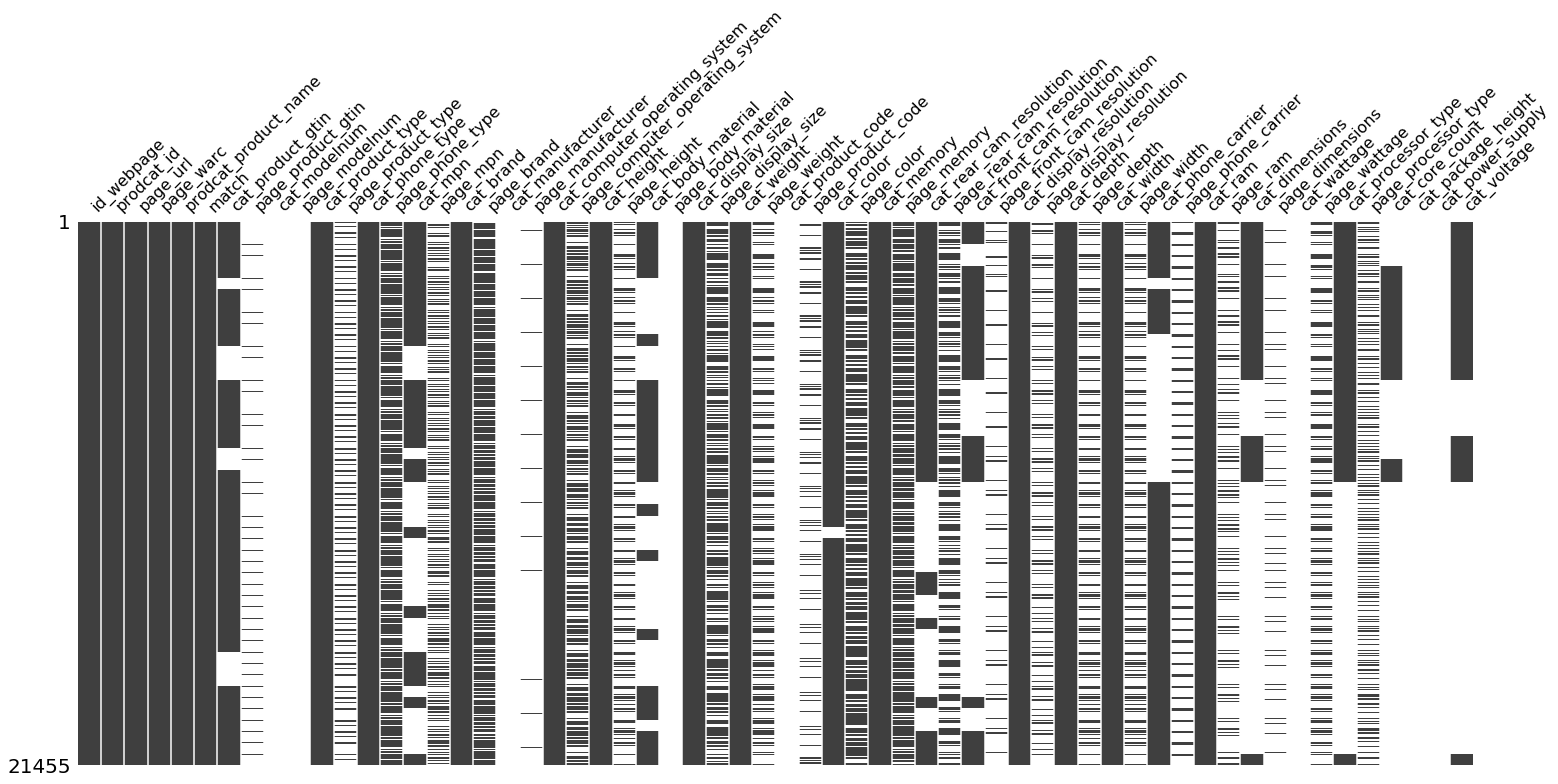

In [26]:
%matplotlib inline
msno.matrix(phone_result_sub,labels=True, sparkline=False)

- Target

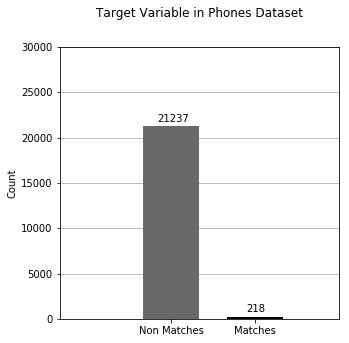

In [76]:
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = [0.2,0.2]
bottom=[0.4,0.7]
vals=list(phone_result_sub['match'].value_counts().values)
label=['Non Matches', 'Matches']
colors=['dimgrey','black']
ax.grid(zorder=0,which='major',axis='y')
ax.bar(bottom, vals, bar_width, color=colors,tick_label=label,align='center',zorder=3)
#plt.grid(b=True, which='major', color='#666666',axis='y')
ax.set_ylabel('Count')
plt.margins()
ax.set_title('Target Variable in Phones Dataset',pad=30)
ax.text(bottom[0]-0.05, vals[0] + 500, str(vals[0]), color='black')
ax.text(bottom[1]-0.03, vals[1] + 500, str(vals[1]), color='black')
plt.ylim([0, 30000])
plt.xlim([0, 1])
plt.show()

## 2.2. HeadPhones

In [77]:
hp_result=pd.read_csv('hp_merged.csv')
hp_result=hp_result.drop(['Unnamed: 0','id'],axis=1)
print(hp_result.shape)
hp_result.head()

/Users/bengikoseoglu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (32,34,41,42,45,52,54,58,64,66,67) have mixed types. Specify dtype option on import or set low_memory=False.



(23087, 69)


id_webpage  match page_headphones_form_factor  \
0     node449b610bd3ad6439d1b26190266d5      0      ear-cup (over the ear)   
1  node4b4dee215b51f2eb45a114409ce7eda6      0      ear-cup (over the ear)   
2    node52a9f6bc8fa1772a0f6a2832641fa1      0                         NaN   
3  node6d72a28b4e6d7d1aff11ebab95221fa1      0      ear-cup (over the ear)   
4     node88b5b595637fff2942878d19b2358      0                         NaN   

         page_mpn page_product_gtin             page_warc page_color  \
0  does not apply    does not apply  ebay.com0.warc.nq.gz      black   
1  does not apply    does not apply  ebay.com0.warc.nq.gz      black   
2  does not apply    does not apply  ebay.com0.warc.nq.gz        NaN   
3  does not apply    does not apply  ebay.com0.warc.nq.gz      black   
4  does not apply    does not apply  ebay.com0.warc.nq.gz        NaN   

  page_brand page_model                                           page_url  \
0        akg   k712 pro  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
1        akg   k712 pro  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
2        akg   k712 pro  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
3        akg   k712 pro  http://www.ebay.com/itm/brand-new-akg-k712-pro...   
4        akg        NaN  http://www.ebay.com/itm/brand-new-akg-k712-pro...   

  page_connectivity_technology page_series page_sensitivity page_product_type  \
0                          NaN         NaN              NaN               NaN   
1                          NaN         NaN              NaN               NaN   
2                          NaN         NaN              NaN               NaN   
3                          NaN         NaN              NaN               NaN   
4                          NaN    k712 pro              NaN               NaN   

  page_headphones_technology page_weight page_frequency_response  \
0                        NaN         NaN                     NaN   
1                        NaN         NaN                     NaN   
2                        NaN         NaN                     NaN   
3                        NaN         NaN                     NaN   
4                        NaN         NaN                     NaN   

  page_impedance page_compatibility page_thd page_included_accessories  \
0        62 ohms                NaN      NaN                       NaN   
1        62 ohms                NaN      NaN                       NaN   
2            NaN                NaN      NaN                       NaN   
3        62 ohms                NaN      NaN                       NaN   
4            NaN                NaN      NaN                       NaN   

  page_warranty page_microphone_sensitivity page_height page_microphone  \
0           NaN                         NaN         NaN             NaN   
1           NaN                         NaN         NaN             NaN   
2           NaN                         NaN         NaN             NaN   
3           NaN                         NaN         NaN             NaN   
4           NaN                         NaN         NaN             NaN   

  page_headphones_cup_type page_max_input_power page_width  \
0            open-air type                  NaN        NaN   
1            open-air type                  NaN        NaN   
2            open-air type                  NaN        NaN   
3            open-air type                  NaN        NaN   
4            open-air type                  NaN        NaN   

  page_cables_included page_magnet_material cat_headphones_technology  \
0                  NaN                  NaN                   dynamic   
1                  NaN                  NaN                   dynamic   
2                  NaN                  NaN                   dynamic   
3                  NaN                  NaN                   dynamic   
4                  NaN                  NaN                   dynamic   

  cat_controls       cat_brand cat_compliant_standards

In [78]:
only_page_columns=[]
print(len(only_page_columns))

0


In [79]:
only_cat_columns=['cat_controls', 'cat_compliant_standards', 'cat_diaphragm', 'cat_foldable', 'cat_depth', 'cat_microphone_response', 'cat_detachable_cable', 'cat_sound_output_mode', 'cat_microphone_audio_details', 'cat_aditional_features','cat_mdoel']
print(len(only_cat_columns))

11


In [80]:
matches=['id_webpage','prodcat_id', 'page_url', 'page_warc', 'prodcat_product_name','match','cat_product_gtin','page_product_gtin', 'cat_product_type', 'page_product_type','cat_model','page_model','cat_brand', 'page_brand', 'cat_microphone', 'page_microphone','cat_connectivity_technology','page_connectivity_technology', 'cat_thd','page_thd', 'cat_warranty', 'page_warranty', 'cat_headphones_form_factor', 'page_headphones_form_factor', 'cat_included_accessories', 'page_included_accessories', 'cat_impedance', 'page_impedance', 'cat_frequency_response', 'page_frequency_response', 'cat_magnet_material', 'page_magnet_material', 'cat_compatibility', 'page_compatibility', 'cat_cables_included', 'page_cables_included', 'cat_mpn', 'page_mpn', 'cat_weight', 'page_weight', 'cat_height', 'page_height', 'cat_width', 'page_width', 'cat_headphones_cup_type','page_headphones_cup_type', 'cat_headphones_technology', 'page_headphones_technology', 'cat_max_input_power', 'page_max_input_power', 'cat_microphone_sensitivity', 'page_microphone_sensitivity', 'cat_sensitivity', 'page_sensitivity', 'cat_color', 'page_color', 'cat_series', 'page_series']
print(len(matches))

58


In [81]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
hp_result_sub=hp_result[cols_inorder]
print(hp_result_sub.shape)
hp_result_sub.head()

(23087, 69)


id_webpage                            prodcat_id  \
0     node449b610bd3ad6439d1b26190266d5  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
1  node4b4dee215b51f2eb45a114409ce7eda6  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
2    node52a9f6bc8fa1772a0f6a2832641fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
3  node6d72a28b4e6d7d1aff11ebab95221fa1  d7130c90-df60-4e0d-a898-ad8e2821dc7f   
4     node88b5b595637fff2942878d19b2358  d7130c90-df60-4e0d-a898-ad8e2821dc7f   

                                            page_url             page_warc  \
0  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
1  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
2  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
3  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   
4  http://www.ebay.com/itm/brand-new-akg-k712-pro...  ebay.com0.warc.nq.gz   

      prodcat_product_name  match cat_product_gtin page_product_gtin  \
0  audio technica ath-m50x      0   04961310125431    does not apply   
1  audio technica ath-m50x      0   04961310125431    does not apply   
2  audio technica ath-m50x      0   04961310125431    does not apply   
3  audio technica ath-m50x      0   04961310125431    does not apply   
4  audio technica ath-m50x      0   04961310125431    does not apply   

  cat_product_type page_product_type cat_model page_model       cat_brand  \
0       headphones               NaN  ath-m50x   k712 pro  audio-technica   
1       headphones               NaN  ath-m50x   k712 pro  audio-technica   
2       headphones               NaN  ath-m50x   k712 pro  audio-technica   
3       headphones               NaN  ath-m50x   k712 pro  audio-technica   
4       headphones               NaN  ath-m50x        NaN  audio-technica   

  page_brand cat_microphone page_microphone cat_connectivity_technology  \
0        akg            NaN             NaN                       wired   
1        akg            NaN             NaN                       wired   
2        akg            NaN             NaN                       wired   
3        akg            NaN             NaN                       wired   
4        akg            NaN             NaN                       wired   

  page_connectivity_technology cat_thd page_thd cat_warranty page_warranty  \
0                          NaN     NaN      NaN     2 years            NaN   
1                          NaN     NaN      NaN     2 years            NaN   
2                          NaN     NaN      NaN     2 years            NaN   
3                          NaN     NaN      NaN     2 years            NaN   
4                          NaN     NaN      NaN     2 years            NaN   

  cat_headphones_form_factor page_headphones_form_factor  \
0     full size, circumaural      ear-cup (over the ear)   
1     full size, circumaural      ear-cup (over the ear)   
2     full size, circumaural                         NaN   
3     full size, circumaural      ear-cup (over the ear)   
4     full size, circumaural                         NaN   

                         cat_included_accessories page_included_accessories  \
0  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
1  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
2  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
3  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   
4  headphones pouch, 6.3 mm (1/4") stereo adapter                       NaN   

  cat_impedance page_impedance cat_frequency_response page_frequency_response  \
0        38 ohm        62 ohms          15 - 28000 hz                     NaN   
1        38 ohm        62 ohms          15 - 28000 hz                     NaN   
2        38 ohm            NaN          15 - 28000 hz                     NaN   
3        38 ohm        62 ohms          15 - 28000 hz                     NaN   
4        38 ohm 

- Statistics

In [82]:
hp_result_stat=get_stats_table(hp_result_sub,only_page_columns,only_cat_columns)
hp_result_stat.to_excel('hp_result_stats.xlsx')
print(hp_result_stat.shape)

(69, 8)


/Users/bengikoseoglu/anaconda3/lib/python3.7/site-packages/xlsxwriter/worksheet.py:912: UserWarning:

Ignoring URL 'http://www.ebay.com/itm/brand-new-akg-k712-pro-reference-studio-headphones/321983441271?_trksid=p2047675.c100005.m1851&_trkparms=aid%3d222007%26algo%3dsic.mbe%26ao%3d1%26asc%3d35694%26meid%3d26edcf5097e84cc096acc1b56a0f7e51%26pid%3d100005%26rk%3d2%26rkt%3d3%26sd%3d252011469094' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS



In [83]:
hp_result_stat

count  no_unique  no_missing  percent_missing  \
column_name                                                                   
id_webpage                    23087        444           0            0.000   
prodcat_id                    23087         50           0            0.000   
page_url                      23087        444           0            0.000   
page_warc                     23087          8           0            0.000   
prodcat_product_name          23087         49           0            0.000   
match                         23087          2           0            0.000   
cat_product_gtin              22199         47         888            0.038   
page_product_gtin              2443          7       20644            0.894   
cat_product_type              23087          6           0            0.000   
page_product_type              1612          7       21475            0.930   
cat_model                     22643         48         444            0.019   
page_model                    15755         73        7332            0.318   
cat_brand                     23087          6           0            0.000   
page_brand                    15963         23        7124            0.309   
cat_microphone                 1776          1       21311            0.923   
page_microphone                  52          1       23035            0.998   
cat_connectivity_technology   22643          3         444            0.019   
page_connectivity_technology   5668         20       17419            0.754   
cat_thd                       10212         13       12875            0.558   
page_thd                       2444         12       20643            0.894   
cat_warranty                  13763          5        9324            0.404   
page_warranty                  1404          3       21683            0.939   
cat_headphones_form_factor    23087          8           0            0.000   
page_headphones_form_factor    9879         56       13208            0.572   
cat_included_accessories      20423         23        2664            0.115   
page_included_accessories      1872         10       21215            0.919   
cat_impedance                 22199         24         888            0.038   
page_impedance                 5511         27       17576            0.761   
cat_frequency_response        23087         37           0            0.000   
page_frequency_response        3536         26       19551            0.847   
...                             ...        ...         ...              ...   
page_weight                    3380         28       19707            0.854   
cat_height                     1332          3       21755            0.942   
page_height                     312          2       22775            0.986   
cat_width                      1332          3       21755            0.942   
page_width                      208          1       22879            0.991   
cat_headphones_cup_type        5328          6       17759            0.769   
page_headphones_cup_type       1143          6       21944            0.950   
cat_headphones_technology     17315          2        5772            0.250   
page_headphones_technology     2756         13       20331            0.881   
cat_max_input_power            2220          3       20867            0.904   
page_max_input_power            312          3       22775            0.986   
cat_microphone_sensitivity    12432         20       10655            0.462   
page_microphone_sensitivity    1404          6       21683            0.939   
cat_sensitivity               20867         32        2220            0.096   
page_sensitivity               5408         33       17679            0.766   
cat_color                      7991          8       15096            0.654   
page_color                    10555         23       12532            0.543   
cat_series                    18647         18        4440            0.192   
p

In [84]:
hp_result_stat[hp_result_stat['percent_missing']==1]

Empty DataFrame
Columns: [count, no_unique, no_missing, percent_missing, only in page, only in catalog, most_freq, no_most_freq]
Index: []

In [85]:
hp_result_stat[(hp_result_stat['percent_missing']>=0.9) & (hp_result_stat['percent_missing']<1.0)]

count  no_unique  no_missing  percent_missing  \
column_name                                                                   
page_product_type              1612          7       21475            0.930   
cat_microphone                 1776          1       21311            0.923   
page_microphone                  52          1       23035            0.998   
page_warranty                  1404          3       21683            0.939   
page_included_accessories      1872         10       21215            0.919   
page_magnet_material            104          1       22983            0.995   
cat_compatibility               444          1       22643            0.981   
page_compatibility             1820          6       21267            0.921   
page_cables_included            156          1       22931            0.993   
cat_height                     1332          3       21755            0.942   
page_height                     312          2       22775            0.986   
cat_width                      1332          3       21755            0.942   
page_width                      208          1       22879            0.991   
page_headphones_cup_type       1143          6       21944            0.950   
cat_max_input_power            2220          3       20867            0.904   
page_max_input_power            312          3       22775            0.986   
page_microphone_sensitivity    1404          6       21683            0.939   
page_series                     884         11       22203            0.962   
cat_controls                    888          2       22199            0.962   
cat_compliant_standards         888          2       22199            0.962   
cat_foldable                   2220          2       20867            0.904   
cat_depth                       888          2       22199            0.962   
cat_microphone_audio_details    888          2       22199            0.962   
cat_aditional_features          443          1       22644            0.981   
cat_mdoel                       444          1       22643            0.981   

                             only in page only in catalog most_freq  \
column_name                                                           
page_product_type                       0               0       nan   
cat_microphone                          0               0       nan   
page_microphone                         0               0       nan   
page_warranty                           0               0       nan   
page_included_accessories               0               0       nan   
page_magnet_material                    0               0       nan   
cat_compatibility                       0               0       nan   
page_compatibility                      0               0       nan   
page_cables_included                    0               0       nan   
cat_height                              0               0       nan   
page_height                             0               0       nan   
cat_width                               0               0       nan   
page_width                              0               0       nan   
page_headphones_cup_type                0               0       nan   
cat_max_input_power                     0               0       nan   
page_max_input_power                    0               0       nan   
page_microphone_sensitivity             0               0       nan   
page_series                             0               0       nan   
cat_controls                            0               1       nan   
cat_compliant_standards                 0               1       nan   
cat_foldable                            0               1       nan   
cat_depth                               0               1       nan   
cat_microphone_audio_details            0               1       nan   
cat_aditional_features                  0               1       nan   
cat_mdoel                               0         

In [86]:
table_cat_hp = ff.create_table(hp_result_stat, index=True, index_title='Headphones Columns')
table_cat_hp.layout.width=3000
iplot(table_cat_hp)

- Missingness

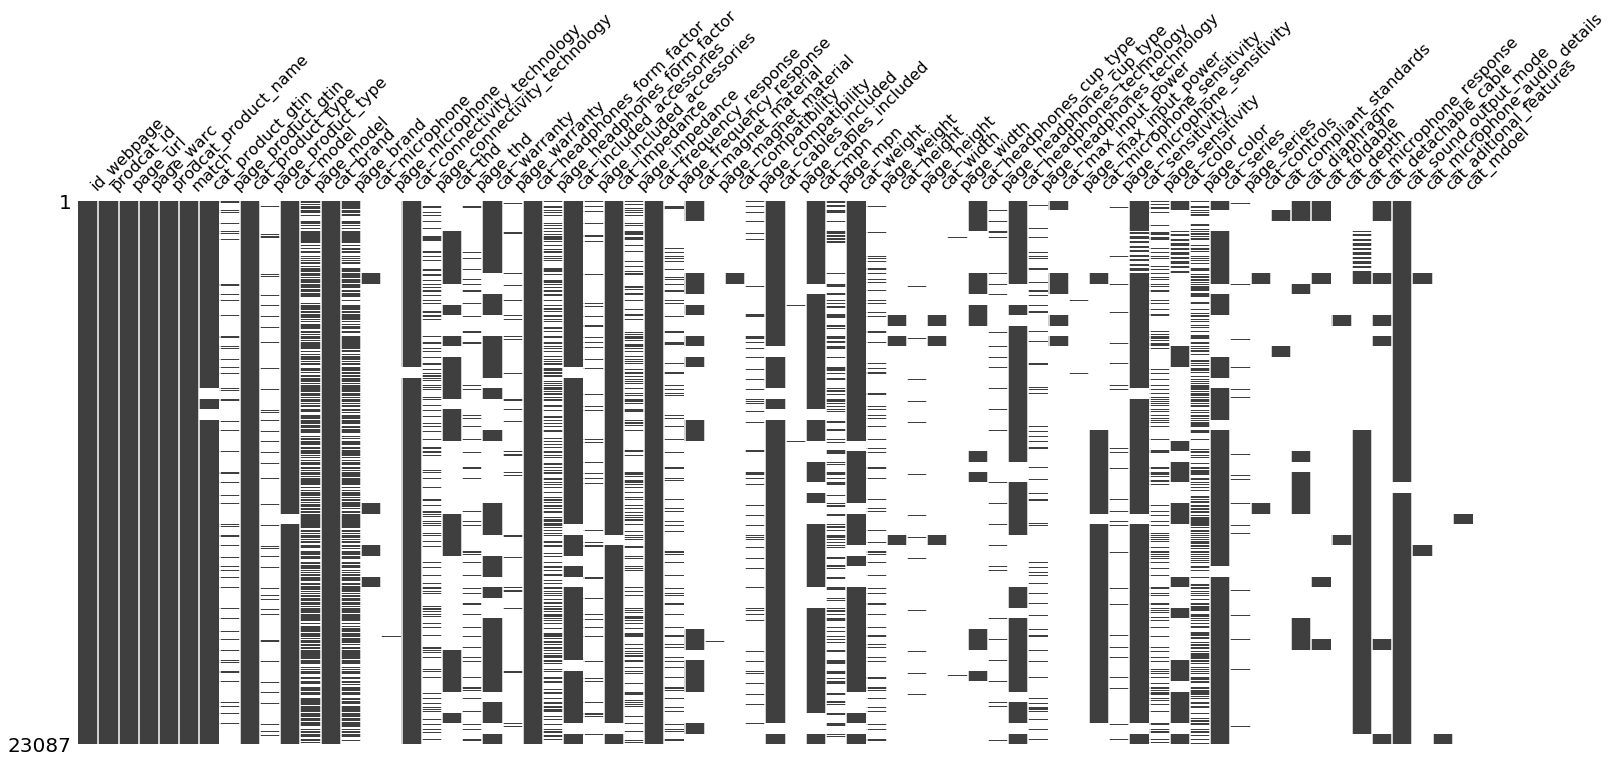

In [87]:
%matplotlib inline
msno.matrix(hp_result_sub,labels=True, sparkline=False)

- Target Variable

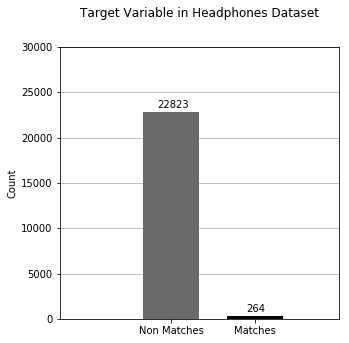

In [88]:
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = [0.2,0.2]
bottom=[0.4,0.7]
vals=list(hp_result_sub['match'].value_counts().values)
label=['Non Matches', 'Matches']
colors=['dimgrey','black']
ax.grid(zorder=0,which='major',axis='y')
ax.bar(bottom, vals, bar_width, color=colors,tick_label=label,align='center',zorder=3)
#plt.grid(b=True, which='major', color='#666666',axis='y')
ax.set_ylabel('Count')
plt.margins()
ax.set_title('Target Variable in Headphones Dataset',pad=30)
ax.text(bottom[0]-0.05, vals[0] + 500, str(vals[0]), color='black')
ax.text(bottom[1]-0.03, vals[1] + 500, str(vals[1]), color='black')
plt.ylim([0, 30000])
plt.xlim([0, 1])
plt.show()

## 2.3. TVs

In [89]:
tv_result=pd.read_csv('tv_merged.csv')
tv_result=tv_result.drop(['Unnamed: 0','id'],axis=1)
print(tv_result.shape)
tv_result.head()

/Users/bengikoseoglu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning:

Columns (128,131,132,134,135,137,138,141,142,144,145,148,149,152,155,156,159,161,162,163,164,165,167,168,169,171,173,174,175,177,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,196,197,198,200,201,203,204,205,206,207,208,209,210,212,213,214,215,216,218,219,220,221,222,224,225,227,228,232,235,237,238,239,241,242,243,244,247,248,249,250,251,252,255,258,259,260,262,265,268,271,274,275,276,277,278,282,283,285,286,287,288,289,290,291,292,293,294,295,296,297,298,300,311,312,313,314,315,316,322,325,335,336,337,338,339,340,341,342,343,345,348,349,350,351,352,353,354,355,356,357,358,360,361,362,365,366,367,368,370,371,372,373,374,375,376,377,379,380,381,382,384,385,386,387,388,404,407,409,410,412,413,414,415,416,417,418,419,420,421,422,423,424,425,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,450,451,452,453,454,455,456,457,461,462,463,464,46

(25679, 556)


id_webpage  match page_closed_captions_(cc)  \
0  node2adaa221ac4791c47f29f345972f1c91      0                       NaN   
1   nodeb452c577135dea4d89c4fcd40b9ac4f      0                       NaN   
2  nodef741bd19171e3c5f35e514b43c112972      0                       NaN   
3  node62aa28f37676c392289b6393a7a550e8      0                       NaN   
4   node66e1a3264db98d4cab3dbe4f9295858      0                       NaN   

  page_subwoofer_out page_dimming_type page_auto_photo_mode page_mhl  \
0                NaN               NaN                  NaN      NaN   
1                NaN               NaN                  NaN      NaN   
2                NaN               NaN                  NaN      NaN   
3                NaN               NaN                  NaN      NaN   
4                NaN               NaN                  NaN      NaN   

  page_5.1_channel_audio_out page_wi-fi_standard  \
0                        NaN                 NaN   
1                        NaN                 NaN   
2                        NaN                 NaN   
3                        NaN                 NaN   
4                        NaN                 NaN   

  page_composite_video_input(s) page_channel_block_(with_password)  \
0                           NaN                                NaN   
1                           NaN                                NaN   
2                           NaN                                NaN   
3                           NaN                                NaN   
4                           NaN                                NaN   

  page_on-screen_clock page_viewing_angle_(up/down) page_auto_shut-off  \
0                  NaN                          NaN                NaN   
1                  NaN                          NaN                NaN   
2                  NaN                          NaN                NaN   
3                  NaN                          NaN                NaN   
4                  NaN                          NaN                NaN   

  page_digital_audio_output(s) page_hdmi_pc_input_format  \
0                          NaN                       NaN   
1                          NaN                       NaN   
2                          NaN                       NaN   
3                          NaN                       NaN   
4                          NaN                       NaN   

  page_digital_out_format page_advanced_contrast_enhancer_(ace) page_net_ad  \
0                     NaN                                   NaN         NaN   
1                     NaN                                   NaN         NaN   
2                     NaN                                   NaN         NaN   
3                     NaN                                   NaN         NaN   
4                     NaN                                   NaN         NaN   

  page_speaker_configuration page_s-master page_stereo_system  \
0                        NaN           NaN                NaN   
1                        NaN           NaN                NaN   
2                        NaN           NaN                NaN   
3                        NaN           NaN                NaN   
4                        NaN           NaN                NaN   

  page_dlna_content page_advanced_auto_volume page_face_area_detection  \
0               NaN                       NaN                      NaN   
1               NaN                       NaN                      NaN   
2               NaN                       NaN                      NaN   
3               NaN                       NaN                      NaN   
4               NaN                       NaN                      NaN   

  page_on/off_timer page_speakers_(total) page_hdmi_connection(s)_(total)  \
0               NaN                   NaN                             NaN   
1               NaN                   NaN                             NaN   
2               NaN                   NaN                

In [90]:
only_page_columns =['page_closed_captions_(cc)','page_subwoofer_out','page_dimming_type',
'page_auto_photo_mode','page_mhl','page_5.1_channel_audio_out','page_wi-fi_standard','page_composite_video_input(s)','page_channel_block_(with_password)','page_on-screen_clock','page_viewing_angle_(up/down)','page_auto_shut-off','page_digital_audio_output(s)','page_hdmi_pc_input_format','page_digital_out_format','page_advanced_contrast_enhancer_(ace)','page_net_ad','page_speaker_configuration','page_s-master','page_stereo_system','page_dlna_content','page_advanced_auto_volume','page_face_area_detection','page_on/off_timer','page_speakers_(total)','page_hdmi_connection(s)_(total)','page_ac_power_input','page_opera_apps_(system)','page_hotel_mode_menu','page_analog_audio_input(s)_(total)','page_power_saving_modes','page_auto_wide','page_parental_control','page_dolby','page_one-touch_mirroring','page_on-screen_display_for_external_input','page_channel_jump','page_signal-to-sound_architecture','page_internet_browser','page_channel_coverage_(digital_terrestrial)','page_power_consumption_(in_operation)_max.','page_live_color_technology','page_rf_connection_input(s)','page_speaker_position','page_multiple_language_display','page_wi-fi_frequency','page_viewing_angle_(right/left)','page_finish_(surface_color)','page_wide_mode','page_sound_effects','page_info_banner','page_headphone/speaker_link','page_component_video_(y/pb/pr)_input(s)','page_edit_channel_labels','page_usb_play','page_channel_coverage_(analog)','page_picture_mode','page_backlight_type','page_hdmi_pc_input','page_show/hide_channels','page_wi-fi_certified','page_rs-232c_control','page_usb_2.0','page_twin_picture','page_number_of_tuners_(terrestrial/cable)','page_tv_sideview','page_tv_system_(digital_cable)','page_channel_coverage_(digital_cable)','page_condition','page_hdcp','page_sleep_wakeup_timer','page_backlight_off_mode','page_search','page_related_search','page_auto_mute_(on_no_signal)','page_headphone_output(s)','page_wi-fi_direct','page_power_requirements_(voltage)','page_phototv_hd','page_screen_size_(cm)','page_tv_system_(analog)','page_clear_phase','page_demo_mode','page_dynamic_backlight_control','page_audio_power_output','page_cinemotion_reverse_3','page_rs-232c_input(s)','page_ethernet_connection(s)','page_tv_system_(digital_terrestrial)','page_output_connectors','page_video_processing','page_sony_original_surround','page_24p_true_cinema_technology','page_internet_epg','page_motionflow_technology','page_photo_sharing_plus_/_photo_share','page_channel_surf','page_usb_play_(contents)','page_power_consumption_(in_standby)','page_mhl_version','page_color_system','page_tv_tweet','page_arc_hdmi_(audio_return_channel)','page_bravia_sync','page_blinking_type','page_power_requirements_(frequency)','page_screen_mirroring(miracast)','page_label_inputs','page_upc','page_cables_included','page_yearly_operating_cost','page_epaet_qualified','page_product_code','page_media_card_slot','page_pc_input','page_height_with_stand','page_display_coating','page_wall_mountable','page_additional_features','page_weight_with_stand','page_video_inputs_qty','page_headphone_jack','page_smart_capable','page_rf_antenna_input','page_v_chip_control','page_curved','page_depth_with_stand','page_energy_star_certified','page_ethernet','page_audio_outputs','page_power_supply','page_ports','page_hdmi','page_scan_format','page_bundled_items','page_input_connectors','page_compatible_tv_type','page_compatible_tv_brand','page_builtin_tuner','page_vga','page_manufacturer','page_analog_tuner','page_component_video','page_digital_audio_output','page_video_signal_standard','page_combo_type','page_video_formats','page_audio_formats','page_composite_video','page_headphone','page_multi_pack_indicator','page_battery_type','page_remote_included','page_green_compliant','page_network_rj45','page_width_with_stand','page_interactive_features','page_3d_glasses_required','page_internet_access','page_media_player','page_pc_streaming','page_usb_standard','page_rms_output_power','page_processor_type','page_website','page_assembled_product_dimensions_(l_x_w_x_h)','page_ean','page_tv_sideview™','page_rs–232c_control','page_auto_shut–off','page_one–touch_mirroring','page_on–screen_display_for_external_input','page_on–screen_clock','page_s–master','page_illumination_led','page_signal–to–sound_architecture','page_country_of_manufacture','page_origin','page_component','page_rs232c','page_shipping_size_(w_x_h_x_d)','page_eco_sensor','page_connectshare™','page_purcolor_(color_accuracy)','page_dtv_tuner_','page_speaker_type','page_vesa_wall_mount_compatibility','page_ultra_clear_panel','page_user_manual','page_yes','page_product_weight_with_stand','page_wi-fi','page_osd_language','page_power_supply_(v)','page_v-chip','page_wattage','page_anynet+™_(hdmi-cec)','page_bd_wise™_plus','page_e-manual','page_uhd_upscaling','page_smart_evolution_ready','page_mobile_to_tv_-_mirroring,_dlna','page_audio_out_(mini_jack)','page_motion_rate*','page_product_weight_without_stand','page_shipping_weight','page_standby_power_consumption','page_apps_platform','page_power_cable','page_smart_hub','page_dimming_technology','page_closed_captioning','page_tv_to_mobile_-_mirroring','page_electronic_program_guide_(channel_guide)','page_energy_star_certified_','page_rf_in_(terrestrial/cable_input)','page_composite_in_(av)','page_sound_effect','page_depth_enhancing_technology','page_digital_audio_out_(optical)','page_processor','page_sound_output_(rms)','page_remote','page_product_size_(w_x_h_x_d)_with_stand','page_dts_premium_sound','page_touchscreen','page_hdtv','page_wall_mount_dimensions','page_additional_deatures_3d','page_has_integrated_speakers','page_manufacturer_part_number','page_batteries_required','page_series_title','page_product_dimensions','page_has_touchscreen','page_languages','page_product_accessories_included','page_industrial','page_interface_type','page_video_game_platform','page_about_the_brand','page_additional_features_3d','page_isbn','page_front_input_connectors','page_energy_star','page_speaker_power','page_remote_control_type_(originally_supplied_by_manufacturer)','page_rear_output_connectors','page_rear_input_connectors','page_product_highlights','page_built-in_tuner','page_supported_resolutions','page_local_diming','page_smart_functionality','page_dimensions_(w_x_h_x_d)_tv_without_stand','page_dimensions_(w_x_h_x_d)_tv_with_stand','page_inputs','page_tv_model','page_important_message','page_board_number','page_warehouse_location','page_part_type','page_smart_tv_features','page_mounting_features','page_ethernet_technology','page_component_in_ports','page_easy_pairing','page_motion_rate','page_digital_audio_out_(optical_)','page_anynet+_(hdmi-cec)','page_connectshare','page_bd_wise_plus','page_mobile_to_tv-mirroring,_dlna','page_rvu','page_motion_control','page_nano_crystal_color','page_item_condition','page_bluetooth','page_stand_type','page_smart_view_2.0','page_fire','page_dtv_tuner','page_briefing_on_tv','page_triluminos_display','page_region_code','page_front_output_connectors','page_exterior_color','page_known_part_number(s)','page_grade','page_known_model(s)','page_marketing_information','page_stand_part_#','page_stand_condition','page_screws__included','page_tv_compatibility','page_supported_models_','page_specifications','page_tv_version_no','page_board_number(s)','page_tv_type_no','page_supported_specifications','page_tv_model_code','page_part_usage','page_compatible_tv_brands','page_tv_model_no','page_picture_engine','page_sound_optimizer','page_analog_tv_reception','page_launch_year','page_skin_naturalizer','page_sound_booster','page_picture_adjustments_lock','page_reflector','page_picture_frame_mode','page_usb_super_multi-format_play','page_input_skip','page_start_up_sony_logo_display','page_image_contrast_ratio','page_panorama','page_hdmi_instaport','page_main_features','page_msrp','page_manufacturer_website_address','page_quantity','page_p/n','page_actual_weight','page_family','page_sony_entertainment_network','page_3d_super-resolution','page_skype','page_x2_widget_(system)','page_fast_zapping','page_seamless_streaming','page_3d_sync_transmitter_integrated','page_auto_3d_depth_adjustment','page_text_search','page_sense_of_quartz','page_bivl_(system)','page_simulated_3d','page_google_tv_sync','page_deep_black_panel','page_wifi_connection','page_display_technology','page_room_type','page_screen_refresh_rate','page_composite_inputs','page_sound_leveler','page_energy_star_qualified','page_component_video_inputs','page_hdmi_inputs','page_watts/channel','page_vesa_mounting','page_product_number','page_speaker_output_power','page_tv_type','page_contained_battery_type','page_important','page_substitute_parts','page_tv_part_types','page_panel_sticker_number','page_compatible_tv_models','page_notes,_comments_&_additional_information','page_mfr_part_number_1','page_internet_streaming_services','page_hdcp_compatible','page_power','page_dimensions_(wxdxh)','page_power_consumption_operational','page_multi-channel_preview','page_manufacturer_warranty','page_speaker_system','page_hdmi_ports_qty','page_lcd_backlight_technology','page_diagonal_size','page_vesa','page_streaming_service','page_family_line','page_compatible_with_','page_gtin','page_country/region_of_manufacture','page_audio/video_inputs','page_wifi','page_led','page_internet_streaming','page_built_ins','page_compliant_standards','page_panel_number','page_model_','page_version','page_interval','page_length_of_cord','page_exposure_time','page_timer_delay','page_operating_temperature','page_battery_life','page_number_of_shots','page_power_source','page_board','page_does_not_apply','page_6870c-0535d','page_t-con','page_lg','page_television_type','page_features','page_assembled_product_weight','page_is_remote_control_included','page_fits_tv_screen_size_up_to']
print(len(only_page_columns))

407


In [91]:
only_cat_columns=['cat_stand', 'cat_wifi_protocol', 'cat_package_height', 'cat_supported_picture_formats', 'cat_package_depth', 'cat_supported_computer_resolution', 'cat_package_width', 'cat_timer_functions', 'cat_memory']
print(len(only_cat_columns))

9


In [92]:
matches = ['id_webpage','prodcat_id','page_url', 'page_warc', 'prodcat_product_name','match','cat_model', 'page_model','cat_mpn', 'page_mpn','cat_product_gtin', 'page_product_gtin','cat_product_type', 'page_product_type', 'cat_brand', 'page_brand', 'cat_pc_interface', 'page_pc_interface', 'cat_motion_enhancement_technology','page_motion_enhancement_technology', 'cat_image_contrast', 'page_image_contrast', 'cat_depth', 'page_depth','cat_height', 'page_height', 'cat_weight', 'page_weight', 'cat_width', 'page_width', 'cat_closed_caption_capability', 'page_closed_caption_capability', 'cat_dimensions_with_stand', 'page_dimensions_with_stand', 'cat_dimensions_without_stand', 'page_dimensions_without_stand', 'cat_analog_tv_tuner', 'page_analog_tv_tuner', 'cat_video_interface', 'page_video_interface', 'cat_viewing_angle', 'page_viewing_angle', 'cat_stand_design', 'page_stand_design', 'cat_tv_tuner', 'page_tv_tuner', 'cat_refresh_rate', 'page_refresh_rate', 'cat_total_size', 'page_total_size', 'cat_yearly_consumption', 'page_yearly_consumption', 'cat_display_resolution', 'page_display_resolution', 'cat_backlight_technology', 'page_backlight_technology', 'cat_image_aspect_ratio', 'page_image_aspect_ratio', 'cat_computer_operating_system', 'page_computer_operating_system', 'cat_response_time', 'page_response_time', 'cat_batteries_included', 'page_contains_batteries', 'cat_hdmi_ports', 'page_hdmi_ports', 'cat_speakers_type', 'page_speakers_type', 'cat_channel_lock', 'page_channel_lock', 'cat_widescreen_modes', 'page_widescreen_modes', 'cat_supported_audio_formats', 'page_supported_audio_formats', 'cat_connectivity', 'page_connectivity', 'cat_series', 'page_series', 'cat_stereo_reception_system', 'page_stereo_reception_system', 'cat_24p_technology', 'page_24p_technology', 'cat_dlna', 'page_dlna', 'cat_supported_memory_cards', 'page_supported_memory_cards', 'cat_commercial_features', 'page_commercial_features', 'cat_digital_tv_tuner', 'page_digital_tv_tuner', 'cat_wattage_operational', 'page_wattage_operational', 'cat_digital_audio_format', 'page_digital_audio_format', 'cat_voltage', 'page_voltage', 'cat_hdcp_compatability', 'page_hdcp_compatability', 'cat_display_type', 'page_display_type', 'cat_remote_control_model', 'page_remote_control_model', 'cat_usb_ports', 'page_usb_ports', 'cat_builtin_dvd_player', 'page_builtin_dvd_player', 'cat_package_weight', 'page_package_weight', 'cat_warranty', 'page_warranty', 'cat_wattage_standby', 'page_wattage_standby', 'cat_audio_surround', 'page_audio_surround', 'cat_internet_services', 'page_internet_services', 'cat_input_video_formats', 'page_input_video_formats', 'cat_brightness', 'page_brightness', 'cat_color', 'page_color', 'cat_speakers_qty', 'page_speakers_qty', 'cat_3d_technology', 'page_3d_technology', 'cat_viewable_size', 'page_viewable_size', 'cat_supported_video_formats', 'page_digital_video_formats', 'cat_supported_languages', 'page_language_options', 'cat_stand_color', 'page_stand_type_(color)', 'cat_secondary_audio_program', 'page_alternate_audio_(digital)', 'cat_compatible_channels', 'page_number_of_channels', 'cat_3d', 'page_3d_format_support']
print(len(matches))

140


In [93]:
cols_inorder= matches.copy()
cols_inorder.extend(only_cat_columns)
cols_inorder.extend(only_page_columns)
tv_result_sub=tv_result[cols_inorder]
print(tv_result_sub.shape)
tv_result_sub.head()

(25679, 556)


id_webpage                            prodcat_id  \
0  node2adaa221ac4791c47f29f345972f1c91  84e2838d-a419-4a5b-a284-9463b01cea52   
1   nodeb452c577135dea4d89c4fcd40b9ac4f  84e2838d-a419-4a5b-a284-9463b01cea52   
2  nodef741bd19171e3c5f35e514b43c112972  84e2838d-a419-4a5b-a284-9463b01cea52   
3  node62aa28f37676c392289b6393a7a550e8  84e2838d-a419-4a5b-a284-9463b01cea52   
4   node66e1a3264db98d4cab3dbe4f9295858  84e2838d-a419-4a5b-a284-9463b01cea52   

                                            page_url                page_warc  \
0  http://www.walmart.com/ip/vizio-d43-c1-43-1080...  walmart.com0.warc.nq.gz   
1  http://www.walmart.com/ip/vizio-d43-c1-43-1080...  walmart.com0.warc.nq.gz   
2  http://www.walmart.com/ip/vizio-d43-c1-43-1080...  walmart.com0.warc.nq.gz   
3  http://www.ebay.com/itm/lg-43uf6400-43-inch-4k...     ebay.com0.warc.nq.gz   
4  http://www.ebay.com/itm/lg-43uf6400-43-inch-4k...     ebay.com0.warc.nq.gz   

  prodcat_product_name  match cat_model page_model      cat_mpn page_mpn  \
0          lg 55eg9600      0  55eg9600     d43-c1  55eg9600/us   d43-c1   
1          lg 55eg9600      0  55eg9600     d43-c1  55eg9600/us   d43-c1   
2          lg 55eg9600      0  55eg9600     d43-c1  55eg9600/us   d43-c1   
3          lg 55eg9600      0  55eg9600   43uf6430  55eg9600/us      NaN   
4          lg 55eg9600      0  55eg9600   43uf6430  55eg9600/us      NaN   

  cat_product_gtin page_product_gtin           cat_product_type  \
0     719192596955               NaN  curved oled tv - smart tv   
1     719192596955               NaN  curved oled tv - smart tv   
2     719192596955               NaN  curved oled tv - smart tv   
3     719192596955               NaN  curved oled tv - smart tv   
4     719192596955               NaN  curved oled tv - smart tv   

  page_product_type cat_brand page_brand cat_pc_interface page_pc_interface  \
0               NaN        lg      vizio              NaN               NaN   
1               NaN        lg      vizio              NaN               NaN   
2               NaN        lg      vizio              NaN               NaN   
3               NaN        lg         lg              NaN               NaN   
4               NaN        lg         lg              NaN               NaN   

  cat_motion_enhancement_technology page_motion_enhancement_technology  \
0                               NaN                                NaN   
1                               NaN                                NaN   
2                               NaN                                NaN   
3                               NaN                                NaN   
4                               NaN                                NaN   

  cat_image_contrast               page_image_contrast cat_depth page_depth  \
0                NaN  200,000 1 dynamic contrast ratio      2 in        NaN   
1                NaN                          200000:1      2 in        NaN   
2                NaN  200,000 1 dynamic contrast ratio      2 in        NaN   
3                NaN                               NaN      2 in        NaN   
4                NaN                               NaN      2 in        NaN   

  cat_height page_height cat_weight page_weight cat_width page_width  \
0    28.3 in         NaN   33.7 lbs         NaN     48 in        NaN   
1    28.3 in         NaN   33.7 lbs         NaN     48 in        NaN   
2    28.3 in         NaN   33.7 lbs         NaN     48 in        NaN   
3    28.3 in         NaN   33.7 lbs         NaN     48 in        NaN   
4    28.3 in         NaN   33.7 lbs         NaN     48 in        NaN   

  cat_closed_caption_capability page_closed_caption_capability  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN      

- Statistics

In [94]:
tv_result_stat=get_stats_table(tv_result_sub,only_page_columns,only_cat_columns)
tv_result_stat.to_excel('tv_result_stats.xlsx')
print(tv_result_stat.shape)

(556, 8)


In [95]:
tv_result_stat

count  no_unique  no_missing  \
column_name                                                        
id_webpage                          25679        428           0   
prodcat_id                          25679         60           0   
page_url                            25679        427           0   
page_warc                           25679          8           0   
prodcat_product_name                25679         60           0   
match                               25679          2           0   
cat_model                           25679         59           0   
page_model                          11459         66       14220   
cat_mpn                             25679         60           0   
page_mpn                            15179        121       10500   
cat_product_gtin                    23967         62        1712   
page_product_gtin                     780          5       24899   
cat_product_type                    25679          5           0   
page_product_type                    4440         20       21239   
cat_brand                           25679          5           0   
page_brand                          18839         12        6840   
cat_pc_interface                    10271          3       15408   
page_pc_interface                     120          2       25559   
cat_motion_enhancement_technology   21399         15        4280   
page_motion_enhancement_technology    120          2       25559   
cat_image_contrast                   3424          7       22255   
page_image_contrast                   419          4       25260   
cat_depth                           23111         30        2568   
page_depth                           2820         18       22859   
cat_height                          23111         40        2568   
page_height                          3060         27       22619   
cat_weight                          23111         53        2568   
page_weight                          2880         22       22799   
cat_width                           23111         44        2568   
page_width                           3060         23       22619   
...                                   ...        ...         ...   
page_compatible_with_                 120          2       25559   
page_gtin                              60          1       25619   
page_country/region_of_manufacture     60          1       25619   
page_audio/video_inputs               120          2       25559   
page_wifi                              60          1       25619   
page_led                               60          1       25619   
page_internet_streaming                60          1       25619   
page_built_ins                         60          1       25619   
page_compliant_standards               60          1       25619   
page_panel_number                     180          2       25499   
page_model_                            60          1       25619   
page_version                           60          1       25619   
page_interval                          60          1       25619   
page_length_of_cord                    60          1       25619   
page_exposure_time                     60          1       25619   
page_timer_delay                       60          1       25619   
page_operating_temperature             60          1       25619   
page_battery_life                      60          1       25619   
page_number_of_shots                   60          1       25619   
page_power_source                      60          1       25619   
page_board                             60          1       25619   
page_does_not_apply                    60          1       25619   
page_6870c-0535d                       60          1       25619   
page_t-con                             60          1       25619   
page_lg                                60          1       25619   
page_television_type                   60          1       25619   
page_features           

In [96]:
tv_result_stat[tv_result_stat['percent_missing']==1]

Empty DataFrame
Columns: [count, no_unique, no_missing, percent_missing, only in page, only in catalog, most_freq, no_most_freq]
Index: []

In [97]:
tv_result_stat[(tv_result_stat['percent_missing']>=0.9) & (tv_result_stat['percent_missing']<1.0)]

count  no_unique  no_missing  \
column_name                                                        
page_product_gtin                     780          5       24899   
page_pc_interface                     120          2       25559   
page_motion_enhancement_technology    120          2       25559   
page_image_contrast                   419          4       25260   
page_closed_caption_capability        360          1       25319   
page_dimensions_with_stand            840          7       24839   
page_dimensions_without_stand         479          6       25200   
page_analog_tv_tuner                   60          1       25619   
page_video_interface                 1260          6       24419   
page_viewing_angle                   1680          9       23999   
page_stand_design                     180          3       25499   
page_tv_tuner                         180          2       25499   
cat_refresh_rate                     1284          2       24395   
page_total_size                      1200          6       24479   
cat_yearly_consumption               2139          4       23540   
page_yearly_consumption               900          6       24779   
page_backlight_technology             300          2       25379   
page_computer_operating_system        240          2       25439   
cat_response_time                    2140          4       23539   
page_response_time                    120          1       25559   
cat_batteries_included               1283          1       24396   
page_contains_batteries               180          1       25499   
page_hdmi_ports                      1200          3       24479   
page_speakers_type                   1440          7       24239   
page_channel_lock                      60          1       25619   
page_widescreen_modes                  60          1       25619   
page_supported_audio_formats          660          2       25019   
page_series                          1800         13       23879   
page_stereo_reception_system           60          1       25619   
page_24p_technology                    60          1       25619   
...                                   ...        ...         ...   
page_compatible_with_                 120          2       25559   
page_gtin                              60          1       25619   
page_country/region_of_manufacture     60          1       25619   
page_audio/video_inputs               120          2       25559   
page_wifi                              60          1       25619   
page_led                               60          1       25619   
page_internet_streaming                60          1       25619   
page_built_ins                         60          1       25619   
page_compliant_standards               60          1       25619   
page_panel_number                     180          2       25499   
page_model_                            60          1       25619   
page_version                           60          1       25619   
page_interval                          60          1       25619   
page_length_of_cord                    60          1       25619   
page_exposure_time                     60          1       25619   
page_timer_delay                       60          1       25619   
page_operating_temperature             60          1       25619   
page_battery_life                      60          1       25619   
page_number_of_shots                   60          1       25619   
page_power_source                      60          1       25619   
page_board                             60          1       25619   
page_does_not_apply                    60          1       25619   
page_6870c-0535d                       60          1       25619   
page_t-con                             60          1       25619   
page_lg                                60          1       25619   
page_television_type                   60          1       25619   
page_features           

In [98]:
table_cat_tv = ff.create_table(tv_result_stat, index=True, index_title='TV Columns')
table_cat_tv.layout.width=3000
iplot(table_cat_tv)

- Missingness

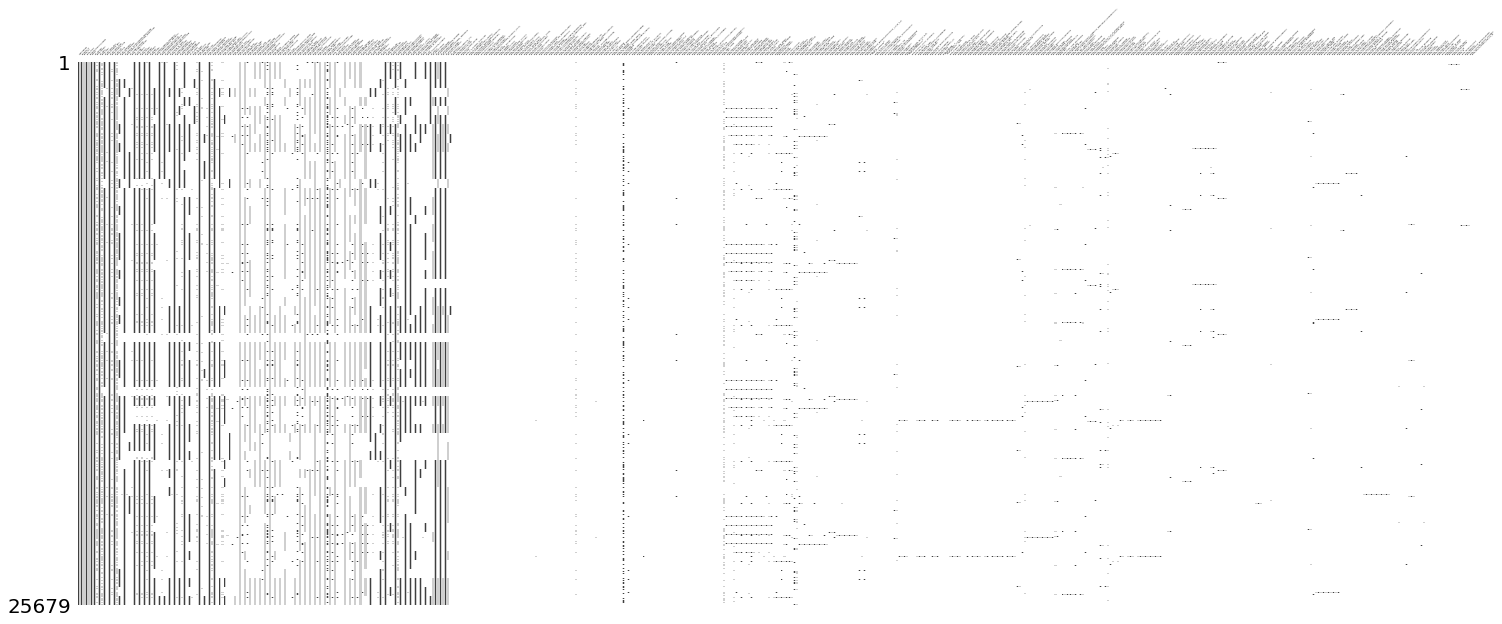

In [99]:
%matplotlib inline
msno.matrix(tv_result_sub,labels=True, sparkline=False, fontsize=2)

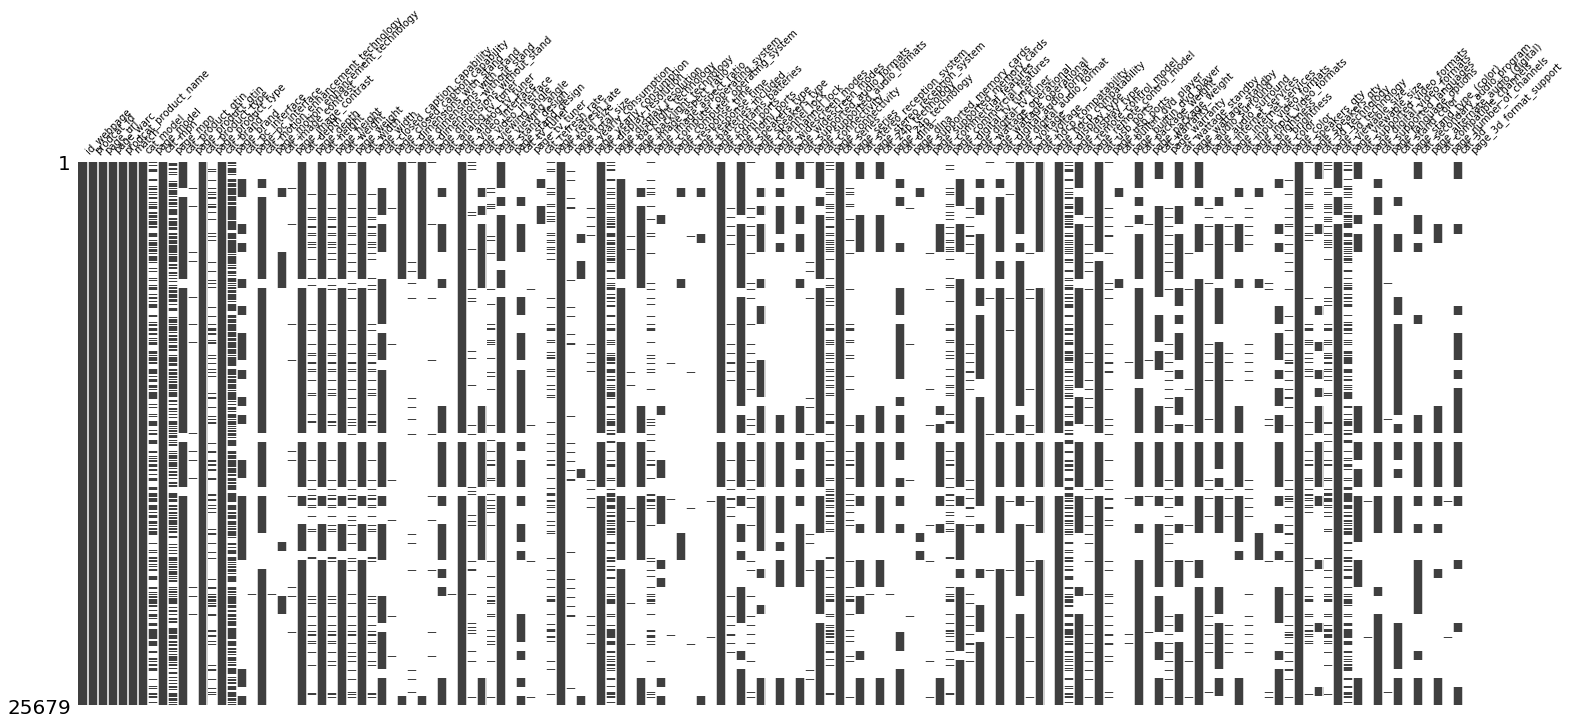

In [100]:
msno.matrix(tv_result_sub[matches],labels=True, sparkline=False, fontsize=10)

In [101]:
tv_result_stat.loc[matches][(tv_result_stat.loc[matches]['percent_missing']>=0.9) & (tv_result_stat.loc[matches]['percent_missing']<1.0)]

count  no_unique  no_missing  \
column_name                                                        
page_product_gtin                     780          5       24899   
page_pc_interface                     120          2       25559   
page_motion_enhancement_technology    120          2       25559   
page_image_contrast                   419          4       25260   
page_closed_caption_capability        360          1       25319   
page_dimensions_with_stand            840          7       24839   
page_dimensions_without_stand         479          6       25200   
page_analog_tv_tuner                   60          1       25619   
page_video_interface                 1260          6       24419   
page_viewing_angle                   1680          9       23999   
page_stand_design                     180          3       25499   
page_tv_tuner                         180          2       25499   
cat_refresh_rate                     1284          2       24395   
page_total_size                      1200          6       24479   
cat_yearly_consumption               2139          4       23540   
page_yearly_consumption               900          6       24779   
page_backlight_technology             300          2       25379   
page_computer_operating_system        240          2       25439   
cat_response_time                    2140          4       23539   
page_response_time                    120          1       25559   
cat_batteries_included               1283          1       24396   
page_contains_batteries               180          1       25499   
page_hdmi_ports                      1200          3       24479   
page_speakers_type                   1440          7       24239   
page_channel_lock                      60          1       25619   
page_widescreen_modes                  60          1       25619   
page_supported_audio_formats          660          2       25019   
page_series                          1800         13       23879   
page_stereo_reception_system           60          1       25619   
page_24p_technology                    60          1       25619   
page_dlna                             240          1       25439   
cat_supported_memory_cards           1284          1       24395   
page_supported_memory_cards           240          1       25439   
page_digital_tv_tuner                1380          3       24299   
page_wattage_operational              300          4       25379   
page_digital_audio_format             480          5       25199   
page_voltage                          660          4       25019   
page_hdcp_compatability                60          1       25619   
page_remote_control_model            1440          5       24239   
page_usb_ports                       1980          8       23699   
cat_builtin_dvd_player                856          1       24823   
page_builtin_dvd_player               180          1       25499   
page_package_weight                   179          2       25500   
page_warranty                        1740          3       23939   
page_wattage_standby                  360          3       25319   
page_audio_surround                   900          1       24779   
page_internet_services                600          3       25079   
page_input_video_formats             1200          8       24479   
cat_brightness                       2140          4       23539   
page_brightness                       300          3       25379   
page_speakers_qty                    2220          2       23459   
page_digital_video_formats            180          1       25499   
page_language_options                 120          1       25559   
page_stand_type_(color)               120          2       25559   
page_alternate_audio_(digital)         60          1       25619   
page_number_of_channels               180          1       25499   
page_3d_format_support                 60          1       25619   

                       

In [102]:
len(tv_result_stat.loc[matches][(tv_result_stat.loc[matches]['percent_missing']>=0.9) & (tv_result_stat.loc[matches]['percent_missing']<1.0)])

57

- Target Variable

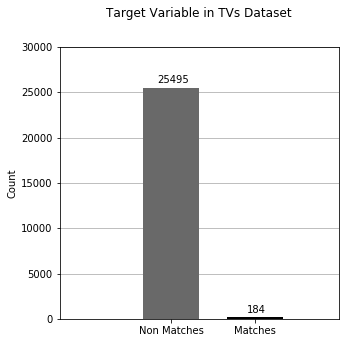

In [103]:
fig, ax = plt.subplots(figsize=(5, 5))
bar_width = [0.2,0.2]
bottom=[0.4,0.7]
vals=list(tv_result_sub['match'].value_counts().values)
label=['Non Matches', 'Matches']
colors=['dimgrey','black']
ax.grid(zorder=0,which='major',axis='y')
ax.bar(bottom, vals, bar_width, color=colors,tick_label=label,align='center',zorder=3)
#plt.grid(b=True, which='major', color='#666666',axis='y')
ax.set_ylabel('Count')
plt.margins()
ax.set_title('Target Variable in TVs Dataset',pad=30)
ax.text(bottom[0]-0.05, vals[0] + 500, str(vals[0]), color='black')
ax.text(bottom[1]-0.03, vals[1] + 500, str(vals[1]), color='black')
plt.ylim([0, 30000])
plt.xlim([0, 1])
plt.show()